In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

from wordcloud import WordCloud, ImageColorGenerator

reddit = pd.read_csv('/content/gdrive/MyDrive/JoeBiden_comments_2020_clean.csv', index_col=[0])
reddit.head(2)

,author,body,created_utc,link_id,parent_id,score
0,nightcloudsky,I feel like I am becoming one with universe ac...,1577837280,t3_eia4d6,t1_fcokn8b,1
1,PotGetsStirred,Thanks for reminding me to go donate a downvot...,1577837752,t3_ei9uvo,t3_ei9uvo,1


База данных содержит селедующие характеристики:

- __author__ – user's nickname on Reddit
- __body__ – user's comment
- __created_utc__ – date in UTC
- __link_id__ – subreddit ID
- __parent_id__ – parent ID
- __score__ – score (Integer)


### Взглянем на данные:

In [ ]:
# Количество наблюдений:
reddit.shape[0]

499528

In [ ]:
# Уникальные наблюдения:
reddit.nunique()

author          49677
body           497737
created_utc    484533
link_id         35853
parent_id      249118
score             103
dtype: int64

In [ ]:
reddit.info() # Общая информация о базе 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 499528 entries, 0 to 499528
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   author       499528 non-null  object
 1   body         499528 non-null  object
 2   created_utc  499528 non-null  int64 
 3   link_id      499528 non-null  object
 4   parent_id    499528 non-null  object
 5   score        499528 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 26.7+ MB


Заметим, что `created_utc` – дата в формате UTC. Здесь ее тип – int64. Исправим это позднее, если потребуется

In [ ]:
(reddit['author'].value_counts() < 2).sum() # Подавляющее число авторов размещало комментарии два и более раз

23962

Мы видим, что большинство авторов встречаются в этом наборе данных два и более раз. Следовательно, мы могли бы включить ник автора в качестве категориальной переменной для дальнейшего анализа. Полагаю, что это было бы полезно в том случае, если бы мы, например, хотели предсказать рейтинг комментария (score).

In [ ]:
reddit['length'] = reddit['body'].str.split().apply(len) # Подсчитаем кол-во слов
reddit['length'].describe()

count    499528.000000
mean         34.675710
std          46.515122
min           6.000000
25%          12.000000
50%          22.000000
75%          40.000000
max        1801.000000
Name: length, dtype: float64

Большинство комментариев имеет длину – не больше 12 символов (Q1 = 12), половина – не больше 22 (Q2 = 22). Среднее значение равно 34, стандартное отклонение 46.51). Комментарии сильно варьируются по длинне

Длинные комментарии получают больше лайков?

Text(0.5, 0, 'Lowest 1000 Comments          Random 1000 Comments          Highest 1000 Comments')

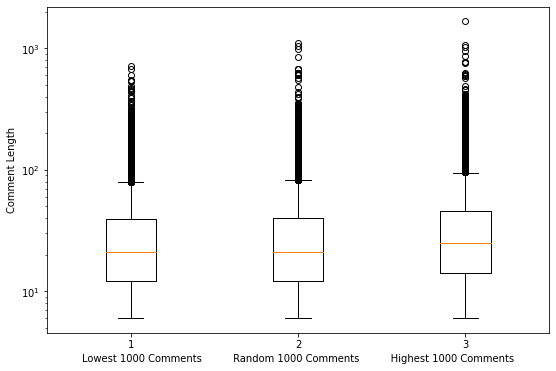

In [ ]:
reddit.sort_values(by=['score'], ascending=False, inplace=True)

low = reddit[:10000]
high = reddit[reddit.shape[0] - 10000:]
random = reddit.sample(n=10000)

lowLen = low['length']
highLen = high['length']
randomLen = random['length']

fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot([lowLen, randomLen, highLen])
ax.set_yscale('log')
plt.ylabel("Comment Length")
plt.xlabel("Lowest 1000 Comments          Random 1000 Comments          Highest 1000 Comments")

Да, самые популярные комментарии, как правило, несколько длиннее

### Score

Рассмотрим распределение рейтинга комментариев:

In [ ]:
reddit['score'].describe()

count    499528.000000
mean          1.044600
std           1.504117
min         -10.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         308.000000
Name: score, dtype: float64

Большинство оценок – в диапазоне от 0 до 5, но рейтинг некоторых комментариев исчисляется сотнями. Среднее значение равно 1, стандартное отклонение 1.50). Рейтинг многих комментариев равен значению по умолчанию – 1.

### Data

In [ ]:
reddit['created_utc'].min() # Наблюдения начинаются с 1 января 2020 г.

1577837280

In [ ]:
reddit['created_utc'].max() #... и заканчиваются 1 января 2021 г.

1609461313

In [ ]:
def utc_to_datetime(data):
    data['year'] = data['created_utc'].apply(lambda utc: datetime.datetime.fromtimestamp(utc).year)
    data['month'] = data['created_utc'].apply(lambda utc: datetime.datetime.fromtimestamp(utc).month)
    data['week'] = data['created_utc'].apply(lambda utc: datetime.datetime.fromtimestamp(utc).weekday())
    data['day'] = data['created_utc'].apply(lambda utc: datetime.datetime.fromtimestamp(utc).day)    
    data['hour'] = data['created_utc'].apply(lambda utc: datetime.datetime.fromtimestamp(utc).hour)

utc_to_datetime(reddit)
reddit.head(2)

,author,body,created_utc,link_id,parent_id,score,year,month,week,day,hour
0,nightcloudsky,I feel like I am becoming one with universe ac...,1577837280,t3_eia4d6,t1_fcokn8b,1,2020,1,2,1,0
1,PotGetsStirred,Thanks for reminding me to go donate a downvot...,1577837752,t3_ei9uvo,t3_ei9uvo,1,2020,1,2,1,0


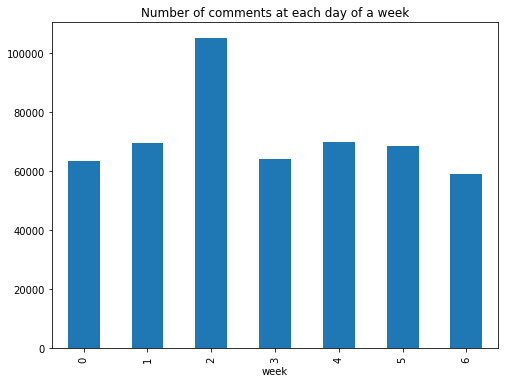

In [ ]:
reddit.groupby(reddit['week']).size().plot(kind='bar', 
                                           title='Number of comments at each day of a week', figsize=(8, 6))

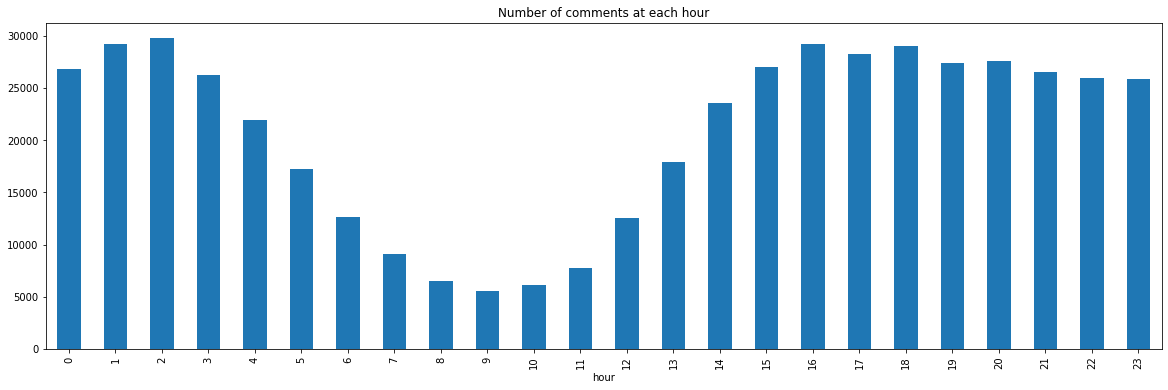

In [ ]:
reddit.groupby(reddit['hour']).size().plot(kind='bar', 
                                           title='Number of comments at each hour', figsize=(20, 6))

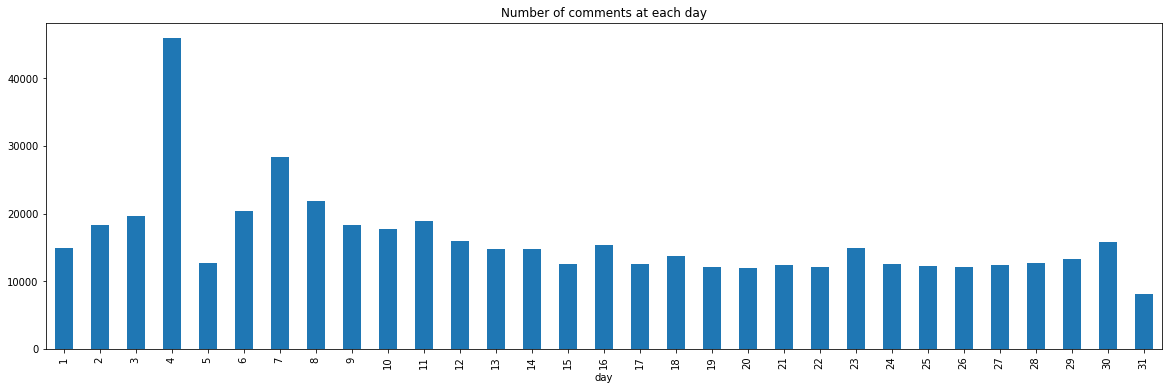

In [ ]:
reddit.groupby(reddit['day']).size().plot(kind='bar', 
                                           title='Number of comments at each day', figsize=(20, 6))

Как мы видим, в будние дни больше всего комментариев. Пик приходится на среду. Вероятнее всего, комментаторы заходят на Reddit в рабочее или учебное время. Возможно, многие из них работают из дома, part-time или являются студентами.

Обратим внимание на распределение комментариев за каждый час. Здесь вырисовывается интересная тенденция. Столбцы выглядят как синусоида, где самое низкое значение приблизительно 9 и максимальное – 16. Как мы видим, большинство пользователей стараются соблюдать цикл бодрствования и сна. Так что, вероятно, публика не такая интернациональная, как я ожидала (аудитория сайта международная, а выборы в США и, в частности, такие видные политические фигуры как кандидаты в презенденты, интересны людям по всему миру). 

Последний график показывает, что пик комментариев пришелся на 4 день месяца, вероятнее, речь идет о 3-4 ноября – дне выборов в США.

### Authors

Давайте посмотрим на авторов комментариев.

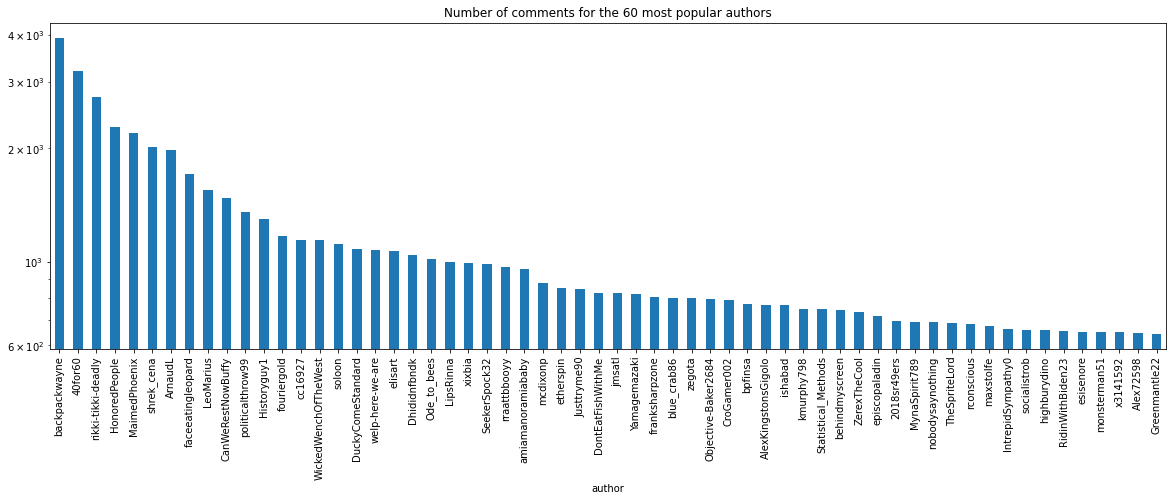

In [ ]:
reddit.groupby(reddit['author']).size().sort_values(ascending=False)[:60].plot(kind='bar', 
                                                                               logy=True, 
                                                                               title="Number of comments for the 60 most popular authors", figsize=(20, 6))

Некоторые пользователи опубликовали 4 * $10^3$ комментария за год. Это примерно 10 комментариев в день. Возможно, некоторые из них – боты. Было бы интересно изучить, о чем они говорят, сколько у них лайков.

Так ли много лайков у топ-3 пользователей по комментариям?

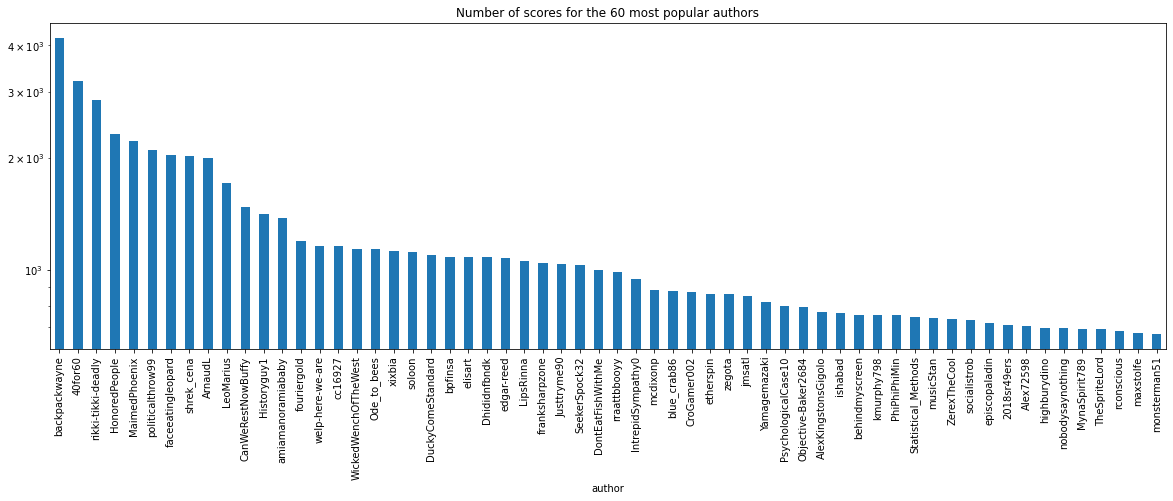

In [ ]:
reddit.groupby(reddit['author'])['score'].sum().sort_values(ascending=False)[:60].plot(kind='bar', 
                                                              logy=True, 
                                                              title="Number of scores for the 60 most popular authors", figsize=(20, 6))

`backpackwayne`, `40for60`, `rikki-tikki-deadly` все также в топе

Давайте теперь посмотрим, о чем же они пишут

In [ ]:
top_3 = ['backpackwayne', '40for60', 'rikki-tikki-deadly']

author_top_1 = reddit[reddit['author'] == 'backpackwayne']
author_top_2 = reddit[reddit['author'] == '40for60']
author_top_3 = reddit[reddit['author'] == 'rikki-tikki-deadly']

word_string_1 = " ".join(author_top_1['body'].str.lower())
word_string_2 = " ".join(author_top_2['body'].str.lower())
word_string_3 = " ".join(author_top_3['body'].str.lower())

#### backpackwayne

(-0.5, 1599.5, 799.5, -0.5)

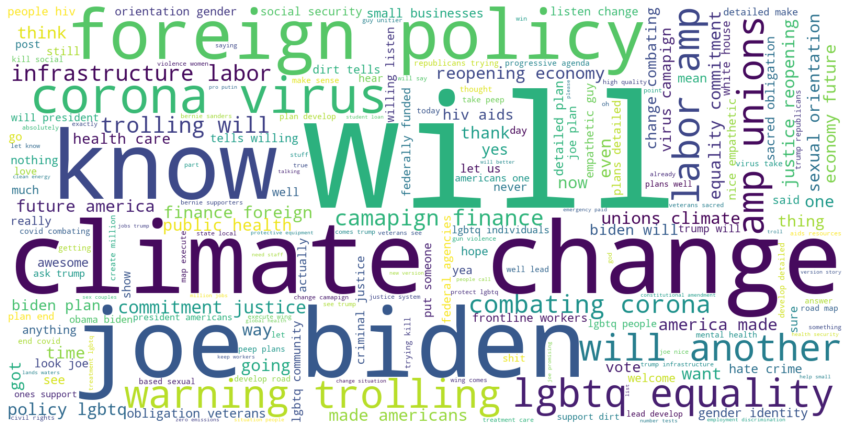

In [ ]:
plt.figure(figsize=(15, 15))
wc = WordCloud(background_color="white", stopwords = STOPWORDS, max_words=200, max_font_size=300,  width=1600, height=800)
wc.generate(word_string_1)
plt.imshow(wc.recolor( colormap='viridis', random_state=42), interpolation="bilinear")
plt.axis('off')

#### 40for60

(-0.5, 1599.5, 799.5, -0.5)

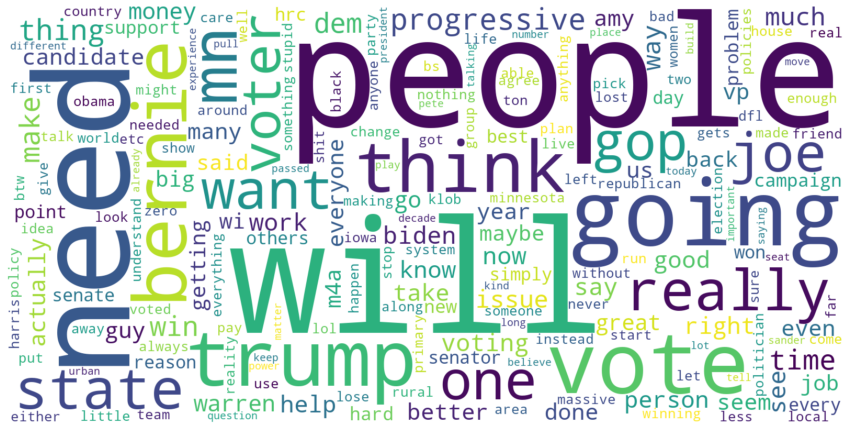

In [ ]:
plt.figure(figsize=(15, 15))
wc = WordCloud(background_color="white", stopwords = STOPWORDS, max_words=200, max_font_size=300,  width=1600, height=800)
wc.generate(word_string_2)
plt.imshow(wc.recolor(colormap='viridis', random_state=42), interpolation="bilinear")
plt.axis('off')

#### rikki-tikki-deadly

(-0.5, 1599.5, 799.5, -0.5)

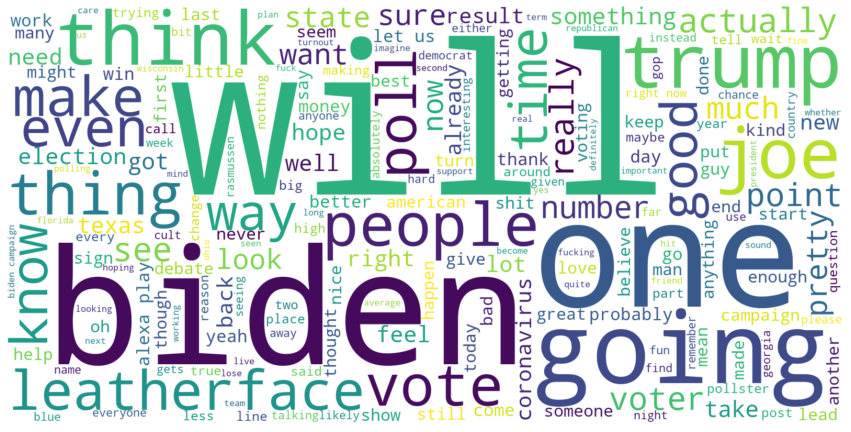

In [ ]:
plt.figure(figsize=(15, 15))
wc = WordCloud(background_color="white", stopwords = STOPWORDS, max_words=200,  width=1600, height=800)
wc.generate(word_string_3)
plt.imshow(wc.recolor(colormap='viridis', random_state=42), interpolation="bilinear")
plt.axis('off')

Все топ-3 комментатора публикуют более-менее схожий контент. Кроме того, ключевые слова (наиболее частотные) – совпадают с политической программой Джо Байдена: ЛГБТ, гендерное равенство, и т.д. Безусловно, этого мало, чтобы понять, боты ли данные пользователи или нет, но, тем не менее, картина проясняется